In [1]:
import argparse, json
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import glob
from tensorboard.backend.event_processing import event_accumulator
import os

In [2]:
#sns.set(style="white")
#sns.set(font_scale=1.4)

width = 8
height = 5.8
plt.figure(figsize=(width, height))
linewidth=1.5
color_set = ["#fb8500","#023047","#e56b6f","#219ebc","#8e7dbe",'#ab3428','#49010f','#bf209f','#d62a9d','#ed317f','#d64072','#5603ad']

def load_data(path,smooth_num):
    data = json.load(open(path, 'rb'))
    y = []
    for i in range(len(data)):
        y.append(data[i][2])
    data = [y[i: i+smooth_num] for i in range(int(len(y)-smooth_num))]
    data = np.asarray(data)
    mean = np.mean(data,axis=1)
    var = np.std(data,axis=1)
    return mean,var

def load_data_tb_v2(path,key_name):
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()
    data = ea.scalars.Items(key_name)
    y = []
    for i in data:
        y.append(i.value)
    return y

def load_all_data_tb_v2(paths,key_names):
    y={}
    
    for ikey in range(len(key_names)):
    #plt.figure(figsize=(10,6))
        y[key_names[ikey]] = []
        for i,path in enumerate(paths):
            cur_y = load_data_tb_v2(path,key_names[ikey])
            y[key_names[ikey]].append(cur_y)
    return y

def comupte_mv_from_y(y,smooth_num,start_value=None):
    m = []
    v = []
    for iy in y:
        if start_value is None:
            prex = [iy[0] for _ in range(smooth_num)]
        else:
            prex = [start_value for _ in range(smooth_num)]
        iy = prex + iy
        data = [iy[i: i+smooth_num] for i in range(int(len(iy)-smooth_num))]
        data = np.asarray(data)
        mean = np.mean(data,axis=1)
        var = np.std(data,axis=1)
        m.append(mean)
        v.append(var)
    return m,v

def load_data_tb(path,smooth_num,key_name,start_value):
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()
    data = ea.scalars.Items(key_name)
    y = []
    if start_value is None:
        for i in range(smooth_num):
            y.append(data[0].value)
    else:
        for i in range(smooth_num):
            y.append(start_value)
    for i in data:
        y.append(i.value)
    data = [y[i: i+smooth_num] for i in range(int(len(y)-smooth_num))]
    data = np.asarray(data)
    mean = np.mean(data,axis=1)
    var = np.std(data,axis=1)
    return mean,var

def load_all_data_tb(paths,smooth_num,key_names,start_value=None):
    m = {}
    v = {}
    
    for ikey in range(len(key_names)):
    #plt.figure(figsize=(10,6))
        m[key_names[ikey]] = []
        v[key_names[ikey]] = []
        for i,path in enumerate(paths):
            if start_value is None:
                cur_m,cur_v = load_data_tb(path,smooth_num[ikey],key_names[ikey],None)
            else:
                cur_m,cur_v = load_data_tb(path,smooth_num[ikey],key_names[ikey], start_value[ikey])
            #cur_m = cur_m[:length[ikey]]
            #cur_v = cur_v[:length[ikey]]
            m[key_names[ikey]].append(cur_m)
            v[key_names[ikey]].append(cur_v)
    return m,v

def get_paths(path):
    path = os.path.join(path,'*','events*')
    paths = glob.glob(path)
    paths.sort()
    
    return paths

def plot_curves(m,v,xs_unit=1,color=None,legend=None,show_legend=True,
                selected_curves=None,length=None,figsize=(12,5), alpha=0.20,legendsize=20,labelsize=20,ticksize=20,dotline=None,
                grid=True,x_label=None,y_label=None,saveinfo=None):
    
    if length is None:
        max_len = 0
        for im in range(len(m)): 
             max_len = max(len(m[im]), max_len)
    else:
        max_len = length
        
    
        
    plt.figure(facecolor="white",figsize=figsize)
    xs = [i*xs_unit for i in range(max_len)]
    if grid:
        plt.grid(which='major',ls='-.')
    if legend is None:
        legend = []
        for i in range(len(m[0])):
            legend.append(i)
    
    m_dotline = []
    v_dotline = []
    if dotline is not None:
        for iline in dotline:
            m_dotline.append(np.array([iline[0] for _ in range(max_len)]))
            v_dotline.append(np.array([iline[1] for _ in range(max_len)]))
            
    if selected_curves is None:
        n_curves = len(m) + len(m_dotline)
        selected_curves = list(range(n_curves))
    else:
        n_curves = len(selected_curves)
    for j in range(len(selected_curves)):
        i = selected_curves[j]
        if i<len(m):
            if length is not None:
                cur_length = min(len(m[i]),length)
            else:
                cur_length = len(m[i])
            if color is not None:
                plt.plot(xs[:cur_length], m[i][:cur_length],linewidth=2,color=color[j],label=legend[i])
                plt.fill_between(xs[:cur_length],m[i][:cur_length]+v[i][:cur_length]/2, m[i][:cur_length]-v[i][:cur_length]/2, alpha=alpha,color=color[j])
            else:
                plt.plot(xs[:cur_length], m[i][:cur_length],linewidth=2,label=legend[i])
                plt.fill_between(xs[:cur_length],m[i][:cur_length]+v[i][:cur_length]/2, m[i][:cur_length]-v[i][:cur_length]/2, alpha=alpha)
        else:
            if length is not None:
                cur_length = min(len(m_dotline[i-len(m)]),length)
            else:
                cur_length = len(m_dotline[i-len(m)])
            if color is not None:
                plt.plot(xs[:cur_length], m_dotline[i-len(m)][:cur_length],linewidth=2,color=color[j],label=legend[i],linestyle='--')
                plt.fill_between(xs[:cur_length],m_dotline[i-len(m)][:cur_length]+v_dotline[i-len(m)][:cur_length]/2, 
                                 m_dotline[i-len(m)][:cur_length]-v_dotline[i-len(m)][:cur_length]/2, alpha=alpha,color=color[j])
            else:
                plt.plot(xs[:cur_length], m_dotline[i-len(m)][:cur_length],linewidth=2,label=legend[i],linestyle='--')
                plt.fill_between(xs[:cur_length],m[i][:cur_length]+v_dotline[i-len(m)][:cur_length]/2, 
                                 m[i][:cur_length]-v_dotline[i-len(m)][:cur_length]/2, alpha=alpha)
    if show_legend:
        plt.legend(fontsize=legendsize)

    font2 = {
    'weight' : 'normal',
    'size' : labelsize,
    }
    if x_label is not None:
        plt.xlabel(x_label,font2)
    if y_label is not None:
        plt.ylabel(y_label,font2)

    plt.tick_params(axis='both',which='major',labelsize=ticksize)
    #my_ticks = np.arange(0,1,4)
    #plt.xticks(my_ticks)
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(xf))
    if saveinfo is not None:
        plt.savefig(saveinfo["name"],format=saveinfo["format"],dpi=saveinfo["dpi"])

<Figure size 576x417.6 with 0 Axes>

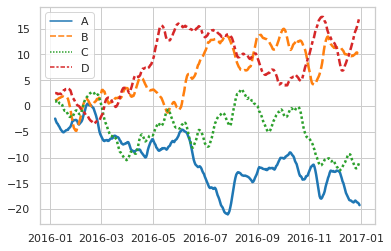

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

rs = np.random.RandomState(365)
values = rs.randn(365, 4).cumsum(axis=0)
dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(values, dates, columns=["A", "B", "C", "D"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)

In [28]:

r1 = np.random.random((1000,))

r2 = 3*(r1-0.5) -95
r2[100:200] += 5.2*np.random.random((100,))
r2[100:400] -= 7.6*np.random.random((300,))
r2[400:1000] += 20.6*np.random.random((600,))

m1,v1 = generate_data(r2.tolist(), 30)

In [30]:
r1 = np.random.random((1000,))

r2 = 10*(r1-0.5) -90
r2[100:200] += 7.2*np.random.random((100,))
r2[200:300] += 12.6*np.random.random((100,))
r2[300:400] += 70.6*np.random.random((100,))
r2[400:500] += 76.6*np.random.random((100,))
r2[500:1000] += 156.6*np.random.random((500,))

m2,v2 = generate_data(r2.tolist(), 30)

In [15]:
data = []
data.append(r2)

In [23]:
m1,v1 = generate_data(r2.tolist(), 30)

In [19]:
def generate_data(y,smooth_num):
    
    data = [y[i: i+smooth_num] for i in range(int(len(y)-smooth_num))]
    data = np.asarray(data)
    mean = np.mean(data,axis=1)
    var = np.std(data,axis=1)
    return mean,var

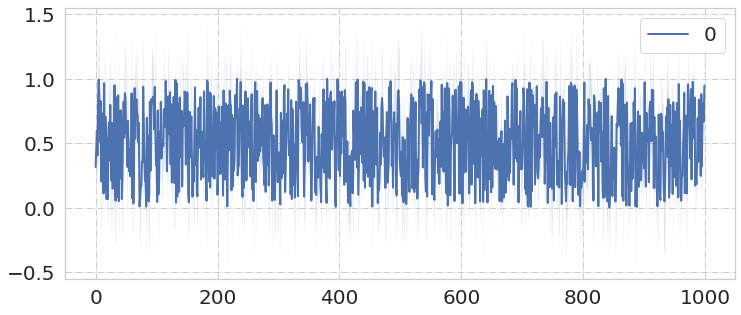

In [6]:
plot_curves(m,v)

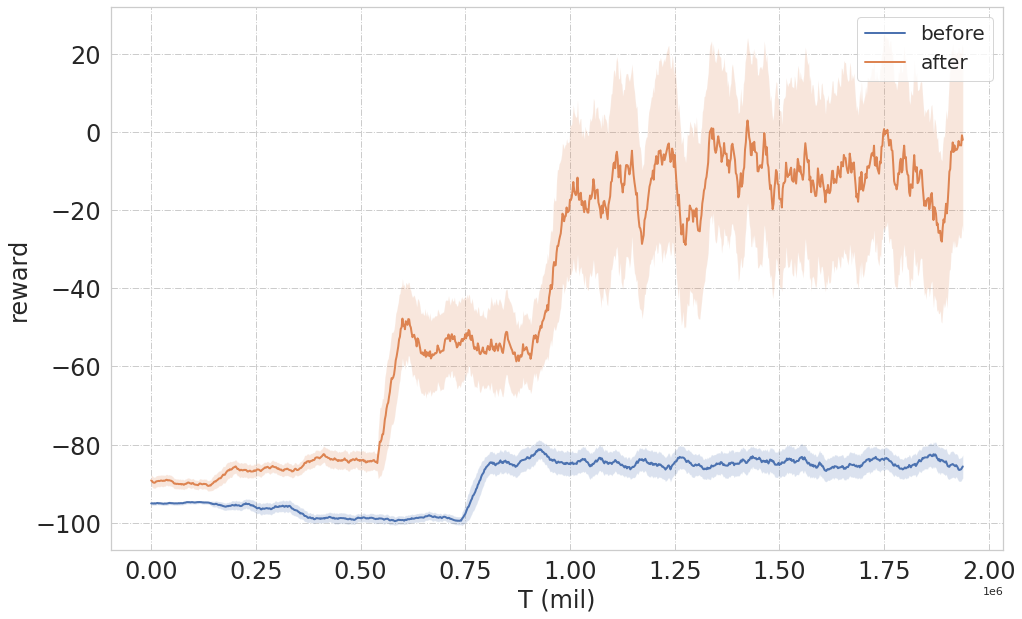

In [32]:
plot_curves([m1,m2],[v1,v2],length=1000,
            legend=["before","after"],
            color=None,x_label="T (mil)",y_label="reward",xs_unit=2000,figsize=(16,10), labelsize=24,ticksize=24,
           saveinfo={'name':'exp1_recsim_final.png','format':'png','dpi':300})

In [42]:
r1 = np.random.random((1000,))

r2 = 10*(r1-0.5) -90
r2[500:1000] = 20*(r1[500:1000]-0.5) - 80
r2[100:200] += 15.2*np.random.random((100,))
r2[200:250] += 3.6*np.random.random((50,))
r2[250:1000] += 22.6*np.random.random((750,))

m1,v1 = generate_data(r2.tolist(), 30)

In [45]:
r1 = np.random.random((1000,))

r2 = 10*(r1-0.5) -90
r2[100:200] += 7.2*np.random.random((100,))
r2[200:300] += 12.6*np.random.random((100,))
r2[300:400] += 70.6*np.random.random((100,))
r2[400:500] += 76.6*np.random.random((100,))
r2[500:1000] += 156.6*np.random.random((500,))

m2,v2 = generate_data(r2.tolist(), 30)

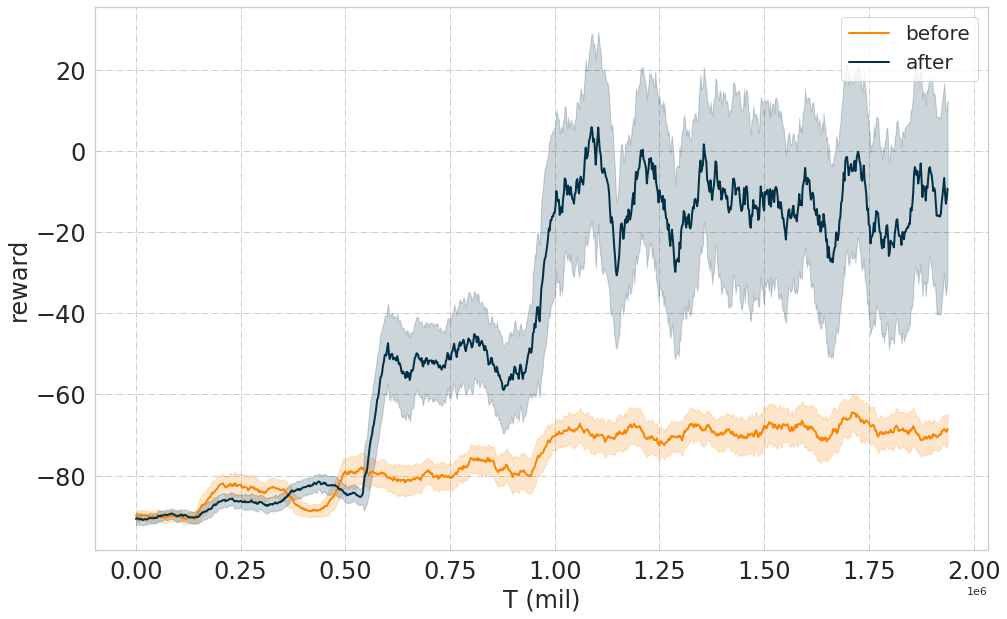

In [47]:
plot_curves([m1,m2],[v1,v2],length=1000,
            legend=["before","after"],
            color=color_set,x_label="T (mil)",y_label="reward",xs_unit=2000,figsize=(16,10), labelsize=24,ticksize=24,
           saveinfo={'name':'exp2.png','format':'png','dpi':300})